> 1. Imports all necessary libraries (e.g., `numpy`, `pandas`, `torch`, `torchvision`, `matplotlib`, etc.)  
> 2. Sets the random seed for reproducibility  
> 3. Identifies the computing device (GPU)  
> 4. Defines constants, including the data path, image size, and the standard CIFAR-10 mean/std  
> 5. Provides an `unpickle` function to read the CIFAR-10 binary files

In [1]:
# ======================================================
# 1. IMPORTS & SETUP
# ======================================================
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Optional: for reproducibility
SEED = 2025
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# If you're running locally (not Kaggle), you might change these paths:
DATA_PATH = "/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py"

# CIFAR-10 constants
NUM_CLASSES = 10
IMG_SIZE = 32
CHANNELS = 3

# Standard CIFAR-10 mean & std
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD  = [0.2470, 0.2435, 0.2616]

def unpickle(file):
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

print("Setup complete.")

Using device: cuda
Setup complete.


> 1. Defines `load_cifar10_train` and `load_cifar10_val` to load the CIFAR-10 training data (50k) and validation data (10k)  
> 2. Implements `convert_data_shape` to reshape data from `(N, 3072)` to `(N, 3, 32, 32)`  
> 3. Implements a custom `CIFARDataset` class to wrap numpy arrays into a PyTorch dataset, applying any image transforms  
> 4. Uses data augmentation (random crop, horizontal flip) and normalization transforms to prepare DataLoaders for training and validation  
> 5. Prints the sizes of the training and validation sets

In [2]:
# ======================================================
# 2. DATA LOADING & PREPROCESSING
# ======================================================

def load_cifar10_train(data_path=DATA_PATH):
    """Load all 5 training batches (total 50,000 images)."""
    all_data = []
    all_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_path, f"data_batch_{i}")
        batch_dict = unpickle(batch_file)
        data = batch_dict[b'data']   # shape: (10000, 3072)
        labels = batch_dict[b'labels']
        all_data.append(data)
        all_labels.extend(labels)
    all_data = np.concatenate(all_data, axis=0)  # (50000, 3072)
    all_labels = np.array(all_labels)            # (50000,)
    return all_data, all_labels

def load_cifar10_val(data_path=DATA_PATH):
    """Load the 'test_batch' as local validation data (10,000 images)."""
    val_dict = unpickle(os.path.join(data_path, "test_batch"))
    val_data = val_dict[b'data']      # (10000, 3072)
    val_labels = val_dict[b'labels']  # (10000,)
    return val_data, np.array(val_labels)

def convert_data_shape(data_array):
    """
    Convert data shape from (N, 3072) to (N, 3, 32, 32).
    3072 = 3 * 32 * 32.
    """
    N = data_array.shape[0]
    data_array = data_array.reshape((N, CHANNELS, IMG_SIZE, IMG_SIZE))
    return data_array

# Custom Dataset classes
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: numpy array (N, 3, 32, 32)
        labels: numpy array (N,) of int
        transform: torchvision transforms
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert to torch.Tensor and scale to [0,1]
        img = torch.tensor(img, dtype=torch.float) / 255.0

        # If we want to apply transforms (which usually expect PIL images),
        # we convert the torch Tensor to a PIL image first.
        if self.transform:
            from torchvision.transforms.functional import to_pil_image
            img = to_pil_image(img)
            img = self.transform(img)

        return img, label

# Load training & validation data
train_data_np, train_labels_np = load_cifar10_train(DATA_PATH)
val_data_np, val_labels_np = load_cifar10_val(DATA_PATH)

train_data_np = convert_data_shape(train_data_np)  # (50000, 3, 32, 32)
val_data_np   = convert_data_shape(val_data_np)    # (10000, 3, 32, 32)

# Transforms for data augmentation & normalization
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
])

# Build Dataset
train_dataset = CIFARDataset(train_data_np, train_labels_np, transform=train_transform)
val_dataset   = CIFARDataset(val_data_np,   val_labels_np,   transform=val_transform)

# Build DataLoader
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train set size: {len(train_dataset)}")
print(f"Val set size:   {len(val_dataset)}")

Train set size: 50000
Val set size:   10000


> 1. Prints the label distribution for both the training and validation sets, helping assess class balance  
> 2. Defines a `show_random_images` function to randomly select and display a few images from the training set  
> 3. Visualizing random images helps confirm that the data is loaded correctly and provides a sense of what the images look like

Train label distribution: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Val label distribution: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


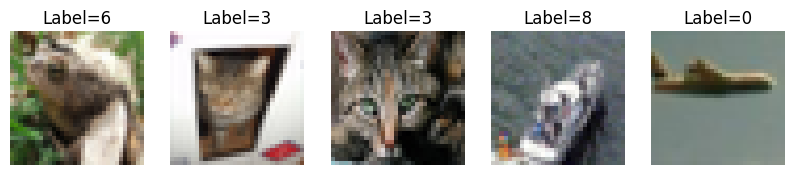

In [3]:
# ======================================================
# 2.1 Basic Data Analysis / Visualization
# ======================================================
import random

# (1) Label distribution
unique, counts = np.unique(train_labels_np, return_counts=True)
print("Train label distribution:", dict(zip(unique, counts)))

unique_val, counts_val = np.unique(val_labels_np, return_counts=True)
print("Val label distribution:", dict(zip(unique_val, counts_val)))

# (2) Visualize a few training images (raw, un-transformed)
def show_random_images(data_np, labels_np, num=5):
    plt.figure(figsize=(num*2, 2))
    for i in range(num):
        idx = random.randint(0, len(data_np)-1)
        img = data_np[idx].transpose(1, 2, 0)  # (3,32,32) -> (32,32,3)
        label = labels_np[idx]
        plt.subplot(1, num, i+1)
        plt.imshow(img.astype('uint8'))
        plt.title(f"Label={label}")
        plt.axis('off')
    plt.show()

show_random_images(train_data_np, train_labels_np, num=5)

In [ ]:
> 1. Defines `BasicBlock`, consisting of two 3×3 convolutions and a residual (shortcut) connection  
> 2. Defines the `ResNet` class, which stacks multiple `BasicBlock`s, including four layers (layer1 to layer4), global average pooling, and a final fully connected layer  
> 3. Provides a `ResNet18` function for instantiating a simplified ResNet-18  
> 4. Creates an instance of the model and moves it to GPU 
> 5. Checks the number of trainable parameters to ensure it does not exceed 5 million

In [4]:
# ======================================================
# 3. MODEL DEFINITION (Modified ResNet)
# ======================================================
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._make_layer(block, 32,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64,  num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        strides = [stride] + [1]*(num_block-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# Create model instance
model = ResNet18(num_classes=NUM_CLASSES).to(DEVICE)

# Check number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params}")
assert num_params <= 5_000_000, "Model has more than 5 million parameters!"

Model parameters: 2797610


> 1. Chooses the loss function (`nn.CrossEntropyLoss`)  
> 2. Selects the optimizer (SGD with momentum) and sets the initial learning rate, momentum, and weight decay  
> 3. Sets up a learning rate scheduler (`MultiStepLR`) to reduce the learning rate at specified epochs (60, 120, 160)  
> 4. Defines the number of training epochs (`EPOCHS`), set to 150
> 5. Prepares lists to record training and validation metrics: `train_losses`, `val_losses`, `train_accs`, `val_accs`  
> 6. Initializes variables for tracking the best validation accuracy (`best_val_acc`) and the path to save the best model weights

In [5]:
# ======================================================
# 4. TRAINING SETUP
# ======================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

EPOCHS = 150  # For demonstration, we set 20. Adjust as needed.

# To record training/validation metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0
best_epoch = 0
save_path = "best_model.pth"  # local checkpoint

print("Training setup complete.")

Training setup complete.


In [ ]:
> 1. For each epoch:
>    - **Training mode**: performs forward pass, computes the loss, backpropagates, and updates parameters for all batches
>    - **Validation mode**: computes the loss and accuracy on the validation set (no gradient updates)
> 2. Records the training/validation loss and accuracy for each epoch  
> 3. Saves model weights to `best_model.pth` if the current validation accuracy surpasses the previous best  
> 4. After all epochs, prints a summary and loads the best model weights

In [6]:
# ======================================================
# 5. TRAINING & VALIDATION LOOP (with logging)
# ======================================================
for epoch in range(1, EPOCHS+1):
    # --------------------
    # TRAIN
    # --------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100. * correct / total

    # --------------------
    # VALIDATE
    # --------------------
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_running_loss / total_val
    val_acc = 100. * correct_val / total_val

    scheduler.step()

    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), save_path)
        print(f"--> Best model updated at epoch {epoch}, val_acc={val_acc:.2f}%")

print(f"Training complete. Best val_acc = {best_val_acc:.2f}% at epoch {best_epoch}")

# Load the best model weights
model.load_state_dict(torch.load(save_path))

Epoch [1/150] Train Loss: 1.6947 | Train Acc: 37.07% || Val Loss: 1.5976 | Val Acc: 40.63%
--> Best model updated at epoch 1, val_acc=40.63%


Epoch [2/150] Train Loss: 1.2261 | Train Acc: 55.54% || Val Loss: 1.1017 | Val Acc: 60.78%
--> Best model updated at epoch 2, val_acc=60.78%


Epoch [3/150] Train Loss: 0.9691 | Train Acc: 65.44% || Val Loss: 0.9858 | Val Acc: 65.46%
--> Best model updated at epoch 3, val_acc=65.46%


Epoch [4/150] Train Loss: 0.8070 | Train Acc: 71.40% || Val Loss: 0.8544 | Val Acc: 70.55%
--> Best model updated at epoch 4, val_acc=70.55%


Epoch [5/150] Train Loss: 0.6962 | Train Acc: 75.89% || Val Loss: 0.7706 | Val Acc: 73.62%
--> Best model updated at epoch 5, val_acc=73.62%


Epoch [6/150] Train Loss: 0.6383 | Train Acc: 78.05% || Val Loss: 0.6965 | Val Acc: 75.80%
--> Best model updated at epoch 6, val_acc=75.80%


Epoch [7/150] Train Loss: 0.5933 | Train Acc: 79.50% || Val Loss: 0.6668 | Val Acc: 77.55%
--> Best model updated at epoch 7, val_acc=77.55%


Epoch [8/150] Train Loss: 0.5584 | Train Acc: 80.71% || Val Loss: 0.8902 | Val Acc: 71.87%


Epoch [9/150] Train Loss: 0.5400 | Train Acc: 81.49% || Val Loss: 0.6551 | Val Acc: 77.46%


Epoch [10/150] Train Loss: 0.5247 | Train Acc: 82.11% || Val Loss: 0.8332 | Val Acc: 72.95%


Epoch [11/150] Train Loss: 0.5025 | Train Acc: 82.61% || Val Loss: 0.7873 | Val Acc: 74.22%


Epoch [12/150] Train Loss: 0.4901 | Train Acc: 83.11% || Val Loss: 0.6287 | Val Acc: 78.90%
--> Best model updated at epoch 12, val_acc=78.90%


Epoch [13/150] Train Loss: 0.4838 | Train Acc: 83.34% || Val Loss: 0.6765 | Val Acc: 77.93%


Epoch [14/150] Train Loss: 0.4748 | Train Acc: 83.73% || Val Loss: 0.6467 | Val Acc: 78.44%


Epoch [15/150] Train Loss: 0.4624 | Train Acc: 84.04% || Val Loss: 0.5920 | Val Acc: 80.45%
--> Best model updated at epoch 15, val_acc=80.45%


Epoch [16/150] Train Loss: 0.4548 | Train Acc: 84.49% || Val Loss: 0.5810 | Val Acc: 80.23%


Epoch [17/150] Train Loss: 0.4475 | Train Acc: 84.75% || Val Loss: 0.5198 | Val Acc: 82.31%
--> Best model updated at epoch 17, val_acc=82.31%


Epoch [18/150] Train Loss: 0.4435 | Train Acc: 84.86% || Val Loss: 0.5123 | Val Acc: 82.76%
--> Best model updated at epoch 18, val_acc=82.76%


Epoch [19/150] Train Loss: 0.4304 | Train Acc: 85.21% || Val Loss: 0.7760 | Val Acc: 77.65%


Epoch [20/150] Train Loss: 0.4346 | Train Acc: 85.02% || Val Loss: 0.7331 | Val Acc: 75.56%


Epoch [21/150] Train Loss: 0.4283 | Train Acc: 85.34% || Val Loss: 0.5449 | Val Acc: 81.45%


Epoch [22/150] Train Loss: 0.4275 | Train Acc: 85.42% || Val Loss: 0.5178 | Val Acc: 82.36%


Epoch [23/150] Train Loss: 0.4124 | Train Acc: 85.83% || Val Loss: 0.5658 | Val Acc: 80.89%


Epoch [24/150] Train Loss: 0.4083 | Train Acc: 86.06% || Val Loss: 0.4826 | Val Acc: 84.16%
--> Best model updated at epoch 24, val_acc=84.16%


Epoch [25/150] Train Loss: 0.4102 | Train Acc: 85.94% || Val Loss: 0.5655 | Val Acc: 81.98%


Epoch [26/150] Train Loss: 0.4080 | Train Acc: 86.05% || Val Loss: 0.5565 | Val Acc: 80.93%


Epoch [27/150] Train Loss: 0.4126 | Train Acc: 85.99% || Val Loss: 0.5574 | Val Acc: 81.54%


Epoch [28/150] Train Loss: 0.4073 | Train Acc: 86.09% || Val Loss: 0.5140 | Val Acc: 82.98%


Epoch [29/150] Train Loss: 0.4050 | Train Acc: 86.09% || Val Loss: 0.7128 | Val Acc: 78.10%


Epoch [30/150] Train Loss: 0.4015 | Train Acc: 86.37% || Val Loss: 0.6024 | Val Acc: 80.68%


Epoch [31/150] Train Loss: 0.4007 | Train Acc: 86.32% || Val Loss: 0.4412 | Val Acc: 84.90%
--> Best model updated at epoch 31, val_acc=84.90%


Epoch [32/150] Train Loss: 0.4000 | Train Acc: 86.34% || Val Loss: 0.6126 | Val Acc: 80.55%


Epoch [33/150] Train Loss: 0.3954 | Train Acc: 86.47% || Val Loss: 0.7298 | Val Acc: 77.06%


Epoch [34/150] Train Loss: 0.3937 | Train Acc: 86.57% || Val Loss: 0.5129 | Val Acc: 83.20%


Epoch [35/150] Train Loss: 0.3933 | Train Acc: 86.54% || Val Loss: 0.5183 | Val Acc: 82.75%


Epoch [36/150] Train Loss: 0.3899 | Train Acc: 86.72% || Val Loss: 0.7962 | Val Acc: 75.49%


Epoch [37/150] Train Loss: 0.3888 | Train Acc: 86.71% || Val Loss: 0.4950 | Val Acc: 83.89%


Epoch [38/150] Train Loss: 0.3877 | Train Acc: 86.63% || Val Loss: 0.5018 | Val Acc: 83.06%


Epoch [39/150] Train Loss: 0.3887 | Train Acc: 86.79% || Val Loss: 0.6611 | Val Acc: 78.55%


Epoch [40/150] Train Loss: 0.3887 | Train Acc: 86.71% || Val Loss: 0.5632 | Val Acc: 81.07%


Epoch [41/150] Train Loss: 0.3865 | Train Acc: 86.83% || Val Loss: 0.9256 | Val Acc: 71.12%


Epoch [42/150] Train Loss: 0.3865 | Train Acc: 86.86% || Val Loss: 0.6392 | Val Acc: 78.84%


Epoch [43/150] Train Loss: 0.3874 | Train Acc: 86.80% || Val Loss: 0.4725 | Val Acc: 83.78%


Epoch [44/150] Train Loss: 0.3820 | Train Acc: 87.03% || Val Loss: 0.6076 | Val Acc: 80.47%


Epoch [45/150] Train Loss: 0.3806 | Train Acc: 87.19% || Val Loss: 0.5338 | Val Acc: 82.69%


Epoch [46/150] Train Loss: 0.3839 | Train Acc: 86.83% || Val Loss: 0.6925 | Val Acc: 78.83%


Epoch [47/150] Train Loss: 0.3782 | Train Acc: 87.16% || Val Loss: 0.7034 | Val Acc: 77.92%


Epoch [48/150] Train Loss: 0.3846 | Train Acc: 86.96% || Val Loss: 0.7461 | Val Acc: 78.03%


Epoch [49/150] Train Loss: 0.3756 | Train Acc: 87.17% || Val Loss: 0.5298 | Val Acc: 82.52%


Epoch [50/150] Train Loss: 0.3809 | Train Acc: 86.98% || Val Loss: 0.6246 | Val Acc: 79.86%


Epoch [51/150] Train Loss: 0.3732 | Train Acc: 87.19% || Val Loss: 0.5163 | Val Acc: 82.97%


Epoch [52/150] Train Loss: 0.3806 | Train Acc: 87.11% || Val Loss: 0.4422 | Val Acc: 85.55%
--> Best model updated at epoch 52, val_acc=85.55%


Epoch [53/150] Train Loss: 0.3702 | Train Acc: 87.31% || Val Loss: 0.6469 | Val Acc: 80.14%


Epoch [54/150] Train Loss: 0.3764 | Train Acc: 87.25% || Val Loss: 0.4739 | Val Acc: 84.50%


Epoch [55/150] Train Loss: 0.3794 | Train Acc: 87.11% || Val Loss: 0.7287 | Val Acc: 78.49%


Epoch [56/150] Train Loss: 0.3781 | Train Acc: 87.08% || Val Loss: 0.4965 | Val Acc: 83.50%


Epoch [57/150] Train Loss: 0.3689 | Train Acc: 87.35% || Val Loss: 0.4801 | Val Acc: 84.19%


Epoch [58/150] Train Loss: 0.3718 | Train Acc: 87.39% || Val Loss: 0.4960 | Val Acc: 83.33%


Epoch [59/150] Train Loss: 0.3755 | Train Acc: 87.23% || Val Loss: 0.5609 | Val Acc: 81.37%


Epoch [60/150] Train Loss: 0.3738 | Train Acc: 87.22% || Val Loss: 0.5058 | Val Acc: 83.31%


Epoch [61/150] Train Loss: 0.2134 | Train Acc: 92.73% || Val Loss: 0.2535 | Val Acc: 91.43%
--> Best model updated at epoch 61, val_acc=91.43%


Epoch [62/150] Train Loss: 0.1693 | Train Acc: 94.22% || Val Loss: 0.2477 | Val Acc: 91.98%
--> Best model updated at epoch 62, val_acc=91.98%


Epoch [63/150] Train Loss: 0.1523 | Train Acc: 94.78% || Val Loss: 0.2535 | Val Acc: 91.64%


Epoch [64/150] Train Loss: 0.1391 | Train Acc: 95.21% || Val Loss: 0.2575 | Val Acc: 91.64%


Epoch [65/150] Train Loss: 0.1378 | Train Acc: 95.27% || Val Loss: 0.2579 | Val Acc: 91.65%


Epoch [66/150] Train Loss: 0.1327 | Train Acc: 95.43% || Val Loss: 0.2811 | Val Acc: 91.01%


Epoch [67/150] Train Loss: 0.1308 | Train Acc: 95.53% || Val Loss: 0.2631 | Val Acc: 91.54%


Epoch [68/150] Train Loss: 0.1285 | Train Acc: 95.62% || Val Loss: 0.2548 | Val Acc: 91.71%


Epoch [69/150] Train Loss: 0.1301 | Train Acc: 95.48% || Val Loss: 0.2668 | Val Acc: 91.51%


Epoch [70/150] Train Loss: 0.1292 | Train Acc: 95.52% || Val Loss: 0.2846 | Val Acc: 91.03%


Epoch [71/150] Train Loss: 0.1290 | Train Acc: 95.58% || Val Loss: 0.2762 | Val Acc: 91.51%


Epoch [72/150] Train Loss: 0.1330 | Train Acc: 95.41% || Val Loss: 0.2890 | Val Acc: 90.66%


Epoch [73/150] Train Loss: 0.1335 | Train Acc: 95.31% || Val Loss: 0.3455 | Val Acc: 89.29%


Epoch [74/150] Train Loss: 0.1311 | Train Acc: 95.46% || Val Loss: 0.3196 | Val Acc: 90.05%


Epoch [75/150] Train Loss: 0.1362 | Train Acc: 95.29% || Val Loss: 0.3958 | Val Acc: 87.77%


Epoch [76/150] Train Loss: 0.1341 | Train Acc: 95.39% || Val Loss: 0.3976 | Val Acc: 87.66%


Epoch [77/150] Train Loss: 0.1360 | Train Acc: 95.18% || Val Loss: 0.3252 | Val Acc: 89.71%


Epoch [78/150] Train Loss: 0.1374 | Train Acc: 95.23% || Val Loss: 0.2993 | Val Acc: 90.54%


Epoch [79/150] Train Loss: 0.1366 | Train Acc: 95.32% || Val Loss: 0.3089 | Val Acc: 90.61%


Epoch [80/150] Train Loss: 0.1328 | Train Acc: 95.41% || Val Loss: 0.2829 | Val Acc: 90.96%


Epoch [81/150] Train Loss: 0.1379 | Train Acc: 95.21% || Val Loss: 0.3246 | Val Acc: 89.71%


Epoch [82/150] Train Loss: 0.1329 | Train Acc: 95.34% || Val Loss: 0.3101 | Val Acc: 90.20%


Epoch [83/150] Train Loss: 0.1400 | Train Acc: 95.18% || Val Loss: 0.3110 | Val Acc: 90.12%


Epoch [84/150] Train Loss: 0.1312 | Train Acc: 95.44% || Val Loss: 0.3447 | Val Acc: 89.06%


Epoch [85/150] Train Loss: 0.1384 | Train Acc: 95.24% || Val Loss: 0.3566 | Val Acc: 88.88%


Epoch [86/150] Train Loss: 0.1347 | Train Acc: 95.38% || Val Loss: 0.3421 | Val Acc: 89.80%


Epoch [87/150] Train Loss: 0.1338 | Train Acc: 95.38% || Val Loss: 0.3232 | Val Acc: 89.95%


Epoch [88/150] Train Loss: 0.1320 | Train Acc: 95.44% || Val Loss: 0.3033 | Val Acc: 90.62%


Epoch [89/150] Train Loss: 0.1343 | Train Acc: 95.32% || Val Loss: 0.3276 | Val Acc: 89.96%


Epoch [90/150] Train Loss: 0.1353 | Train Acc: 95.28% || Val Loss: 0.3289 | Val Acc: 90.00%


Epoch [91/150] Train Loss: 0.1301 | Train Acc: 95.44% || Val Loss: 0.3416 | Val Acc: 89.60%


Epoch [92/150] Train Loss: 0.1337 | Train Acc: 95.39% || Val Loss: 0.3064 | Val Acc: 90.80%


Epoch [93/150] Train Loss: 0.1303 | Train Acc: 95.54% || Val Loss: 0.3564 | Val Acc: 89.37%


Epoch [94/150] Train Loss: 0.1342 | Train Acc: 95.39% || Val Loss: 0.3066 | Val Acc: 90.71%


Epoch [95/150] Train Loss: 0.1292 | Train Acc: 95.53% || Val Loss: 0.3562 | Val Acc: 89.31%


Epoch [96/150] Train Loss: 0.1316 | Train Acc: 95.47% || Val Loss: 0.3369 | Val Acc: 90.07%


Epoch [97/150] Train Loss: 0.1262 | Train Acc: 95.62% || Val Loss: 0.3882 | Val Acc: 88.14%


Epoch [98/150] Train Loss: 0.1347 | Train Acc: 95.29% || Val Loss: 0.3051 | Val Acc: 90.55%


Epoch [99/150] Train Loss: 0.1282 | Train Acc: 95.57% || Val Loss: 0.3625 | Val Acc: 88.89%


Epoch [100/150] Train Loss: 0.1295 | Train Acc: 95.60% || Val Loss: 0.3293 | Val Acc: 90.17%


Epoch [101/150] Train Loss: 0.1248 | Train Acc: 95.58% || Val Loss: 0.3120 | Val Acc: 90.56%


Epoch [102/150] Train Loss: 0.1199 | Train Acc: 95.89% || Val Loss: 0.4235 | Val Acc: 88.01%


Epoch [103/150] Train Loss: 0.1251 | Train Acc: 95.65% || Val Loss: 0.3408 | Val Acc: 89.68%


Epoch [104/150] Train Loss: 0.1306 | Train Acc: 95.49% || Val Loss: 0.2980 | Val Acc: 90.66%


Epoch [105/150] Train Loss: 0.1244 | Train Acc: 95.71% || Val Loss: 0.3229 | Val Acc: 89.66%


Epoch [106/150] Train Loss: 0.1242 | Train Acc: 95.74% || Val Loss: 0.3512 | Val Acc: 89.20%


Epoch [107/150] Train Loss: 0.1208 | Train Acc: 95.79% || Val Loss: 0.3156 | Val Acc: 90.10%


Epoch [108/150] Train Loss: 0.1279 | Train Acc: 95.51% || Val Loss: 0.3315 | Val Acc: 89.83%


Epoch [109/150] Train Loss: 0.1257 | Train Acc: 95.60% || Val Loss: 0.3753 | Val Acc: 88.62%


Epoch [110/150] Train Loss: 0.1250 | Train Acc: 95.72% || Val Loss: 0.3002 | Val Acc: 90.85%


Epoch [111/150] Train Loss: 0.1214 | Train Acc: 95.85% || Val Loss: 0.2894 | Val Acc: 91.00%


Epoch [112/150] Train Loss: 0.1201 | Train Acc: 95.85% || Val Loss: 0.3060 | Val Acc: 90.52%


Epoch [113/150] Train Loss: 0.1212 | Train Acc: 95.90% || Val Loss: 0.3371 | Val Acc: 89.60%


Epoch [114/150] Train Loss: 0.1218 | Train Acc: 95.85% || Val Loss: 0.3543 | Val Acc: 89.32%


Epoch [115/150] Train Loss: 0.1179 | Train Acc: 95.99% || Val Loss: 0.3137 | Val Acc: 90.20%


Epoch [116/150] Train Loss: 0.1188 | Train Acc: 95.80% || Val Loss: 0.4080 | Val Acc: 88.60%


Epoch [117/150] Train Loss: 0.1177 | Train Acc: 95.89% || Val Loss: 0.3679 | Val Acc: 88.94%


Epoch [118/150] Train Loss: 0.1201 | Train Acc: 95.81% || Val Loss: 0.3248 | Val Acc: 90.23%


Epoch [119/150] Train Loss: 0.1201 | Train Acc: 95.88% || Val Loss: 0.2979 | Val Acc: 90.99%


Epoch [120/150] Train Loss: 0.1218 | Train Acc: 95.85% || Val Loss: 0.3397 | Val Acc: 89.54%


Epoch [121/150] Train Loss: 0.0569 | Train Acc: 98.16% || Val Loss: 0.2173 | Val Acc: 93.50%
--> Best model updated at epoch 121, val_acc=93.50%


Epoch [122/150] Train Loss: 0.0354 | Train Acc: 98.96% || Val Loss: 0.2166 | Val Acc: 93.80%
--> Best model updated at epoch 122, val_acc=93.80%


Epoch [123/150] Train Loss: 0.0280 | Train Acc: 99.19% || Val Loss: 0.2183 | Val Acc: 93.85%
--> Best model updated at epoch 123, val_acc=93.85%


Epoch [124/150] Train Loss: 0.0234 | Train Acc: 99.38% || Val Loss: 0.2182 | Val Acc: 93.95%
--> Best model updated at epoch 124, val_acc=93.95%


Epoch [125/150] Train Loss: 0.0209 | Train Acc: 99.44% || Val Loss: 0.2220 | Val Acc: 93.77%


Epoch [126/150] Train Loss: 0.0186 | Train Acc: 99.51% || Val Loss: 0.2171 | Val Acc: 94.12%
--> Best model updated at epoch 126, val_acc=94.12%


Epoch [127/150] Train Loss: 0.0158 | Train Acc: 99.62% || Val Loss: 0.2237 | Val Acc: 93.99%


Epoch [128/150] Train Loss: 0.0152 | Train Acc: 99.61% || Val Loss: 0.2200 | Val Acc: 94.02%


Epoch [129/150] Train Loss: 0.0131 | Train Acc: 99.71% || Val Loss: 0.2296 | Val Acc: 93.81%


Epoch [130/150] Train Loss: 0.0127 | Train Acc: 99.69% || Val Loss: 0.2214 | Val Acc: 94.06%


Epoch [131/150] Train Loss: 0.0126 | Train Acc: 99.64% || Val Loss: 0.2285 | Val Acc: 93.89%


Epoch [132/150] Train Loss: 0.0115 | Train Acc: 99.72% || Val Loss: 0.2255 | Val Acc: 93.99%


Epoch [133/150] Train Loss: 0.0112 | Train Acc: 99.72% || Val Loss: 0.2302 | Val Acc: 93.96%


Epoch [134/150] Train Loss: 0.0108 | Train Acc: 99.76% || Val Loss: 0.2307 | Val Acc: 94.04%


Epoch [135/150] Train Loss: 0.0094 | Train Acc: 99.80% || Val Loss: 0.2279 | Val Acc: 94.20%
--> Best model updated at epoch 135, val_acc=94.20%


Epoch [136/150] Train Loss: 0.0094 | Train Acc: 99.79% || Val Loss: 0.2238 | Val Acc: 94.04%


Epoch [137/150] Train Loss: 0.0092 | Train Acc: 99.81% || Val Loss: 0.2339 | Val Acc: 93.88%


Epoch [138/150] Train Loss: 0.0092 | Train Acc: 99.80% || Val Loss: 0.2326 | Val Acc: 94.02%


Epoch [139/150] Train Loss: 0.0086 | Train Acc: 99.82% || Val Loss: 0.2336 | Val Acc: 94.14%


Epoch [140/150] Train Loss: 0.0082 | Train Acc: 99.83% || Val Loss: 0.2332 | Val Acc: 93.88%


Epoch [141/150] Train Loss: 0.0083 | Train Acc: 99.84% || Val Loss: 0.2389 | Val Acc: 93.85%


Epoch [142/150] Train Loss: 0.0080 | Train Acc: 99.84% || Val Loss: 0.2362 | Val Acc: 93.94%


Epoch [143/150] Train Loss: 0.0083 | Train Acc: 99.82% || Val Loss: 0.2366 | Val Acc: 94.00%


Epoch [144/150] Train Loss: 0.0075 | Train Acc: 99.87% || Val Loss: 0.2357 | Val Acc: 93.86%


Epoch [145/150] Train Loss: 0.0068 | Train Acc: 99.86% || Val Loss: 0.2316 | Val Acc: 94.15%


Epoch [146/150] Train Loss: 0.0081 | Train Acc: 99.82% || Val Loss: 0.2342 | Val Acc: 93.84%


Epoch [147/150] Train Loss: 0.0074 | Train Acc: 99.85% || Val Loss: 0.2321 | Val Acc: 94.00%


Epoch [148/150] Train Loss: 0.0074 | Train Acc: 99.85% || Val Loss: 0.2373 | Val Acc: 94.01%


Epoch [149/150] Train Loss: 0.0068 | Train Acc: 99.86% || Val Loss: 0.2292 | Val Acc: 94.02%


Epoch [150/150] Train Loss: 0.0063 | Train Acc: 99.88% || Val Loss: 0.2279 | Val Acc: 94.17%
Training complete. Best val_acc = 94.20% at epoch 135


<ipython-input-6-90d44a2b4fe7>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

> 1. Uses Matplotlib to plot the training and validation loss curves  
> 2. Plots the training and validation accuracy curves  
> 3. Allows you to visually inspect how the model’s performance evolves over the epochs

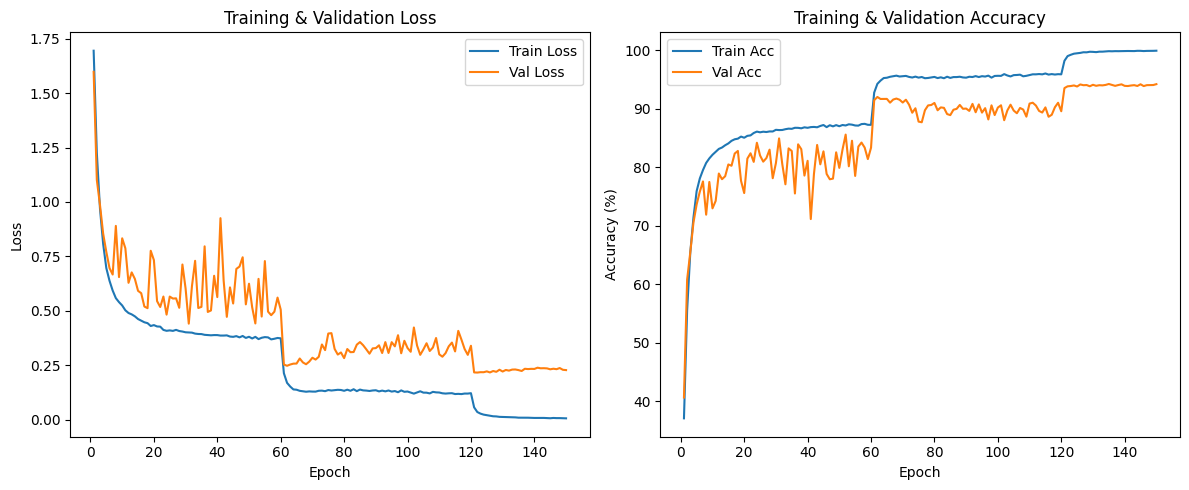

In [7]:
# ======================================================
# 5.1 Visualize Training Curves
# ======================================================
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accs, label='Train Acc')
plt.plot(range(1, EPOCHS+1), val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

> 1. Evaluates the final (best) model on the validation set, computing accuracy  
> 2. Generates a confusion matrix using `confusion_matrix` and visualizes it with Seaborn  
> 3. Helps identify which classes are well-predicted and which are frequently misclassified, guiding future improvements

Validation Accuracy (final) = 94.20%


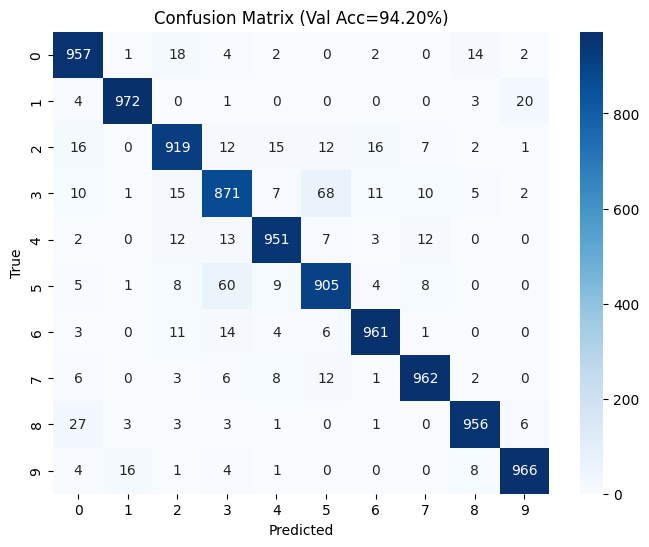

In [8]:
# ======================================================
# 5.2 Evaluate on Validation Set - Confusion Matrix
# ======================================================
from sklearn.metrics import confusion_matrix, accuracy_score

model.eval()
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds_val.extend(predicted.cpu().numpy().tolist())
        all_labels_val.extend(labels.cpu().numpy().tolist())

acc_val = accuracy_score(all_labels_val, all_preds_val)
cm = confusion_matrix(all_labels_val, all_preds_val)
print(f"Validation Accuracy (final) = {acc_val*100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Val Acc={acc_val*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

> Summarizes the overall process and results:
> - Final validation accuracy:94.20%  
> - Best epoch:135  
> - Parameter count:2797610  